In [1]:
import os
import json
import argparse
import torch
import random
import numpy as np
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from dataloader.dataloader import CreateLoaders
from pickle import dump
import pkbar
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import pandas as pd
from pickle import load
from models.mnf_models import MNFNet_v3
import torch.nn.functional as F
from torch.utils.data import Subset
from dataloader.create_data import create_dataset

def return_data(config,method):

    # Setup random seed
    torch.manual_seed(config['seed'])
    np.random.seed(config['seed'])
    random.seed(config['seed'])
    torch.cuda.manual_seed(config['seed'])

    print('Creating Loaders.')
    if method == "BLOC":
        input_shape = 182 ### Hard Coded features
        config['dataset']['path_to_csv'] = config['dataset']['BLOC']
        print("Training on BLOC features.")
    elif method == "BOTOMETER":
        input_shape = 1209#### Hard Coded features
        config['dataset']['path_to_csv'] = config['dataset']['BOTOMETER']
        print("Training on Botometer features.")
    else:
        print("Incorrect method choice. Please choose from: ")
        print("1. BLOC")
        print("2. BOTOMETER")
        exit()

    X_train,X_test,X_val,y_train,y_test,y_val = create_dataset(config['dataset']['path_to_csv'],method=method)
    return X_train,X_test,X_val,y_train,y_test,y_val
    
config = json.load(open("config/default_config.json"))

_,X_test,_,_,y_test,_ = return_data(config,method="BLOC")

C:\Users\James\.conda\envs\ptorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Creating Loaders.
Training on BLOC features.
Start to load the features
Undersampling humans.
Training fraction:  0.6456643162231153 0.6456643162231153
Validation fraction:  0.13836024970303537 0.13836024970303537
Testing fraction:  0.13836024970303537 0.13836024970303537


In [2]:
results_bloc = pd.read_csv(os.path.join(config['Inference']['out_dir_BLOC'],"Inference.csv"),sep=',',index_col=None)
results_bloc = results_bloc[results_bloc.method == 'Testing']
results_bloc

y_hat  y_hat_sigma  y_true  aleatoric   method  y_hat_mlp  \
0      0.047113     0.027923     0.0   0.019618  Testing   0.023423   
1      0.176931     0.069936     0.0   0.091210  Testing   0.268542   
2      0.875169     0.046219     1.0   0.049243  Testing   0.974344   
3      0.157440     0.071700     0.0   0.161411  Testing   0.202785   
4      0.999821     0.000281     1.0   0.000280  Testing   0.999943   
...         ...          ...     ...        ...      ...        ...   
10944  0.999891     0.000209     1.0   0.000156  Testing   0.999821   
10945  0.999642     0.000418     1.0   0.000622  Testing   0.998981   
10946  0.585426     0.123095     0.0   0.135094  Testing   0.455989   
10947  0.007853     0.004314     0.0   0.006401  Testing   0.025683   
10948  0.001914     0.001343     0.0   0.000826  Testing   0.000181   

       y_true_mlp  
0             0.0  
1             0.0  
2             1.0  
3             0.0  
4             1.0  
...           ...  
10944         1.0  
10945         1.0  
10946         0.0  
10947         0.0  
10948         0.0  

[10949 rows x 7 columns]

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE


X = X_test.copy()
tsne = TSNE(n_components=2, random_state=0,perplexity=75)
X_tsne = tsne.fit_transform(X)

# Color by uncertainty

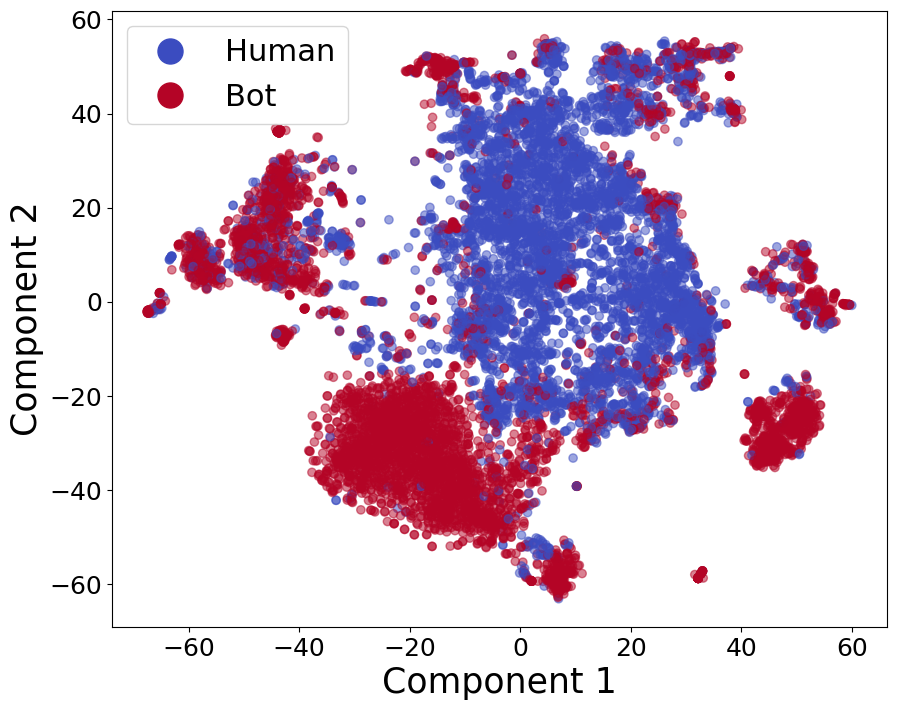

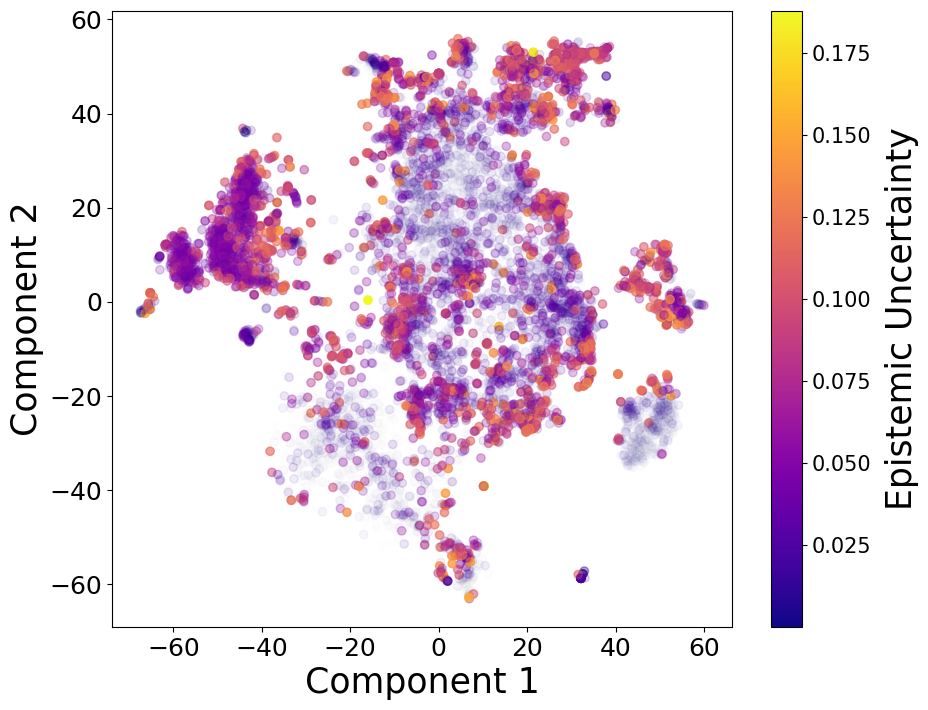

<Figure size 1000x800 with 0 Axes>

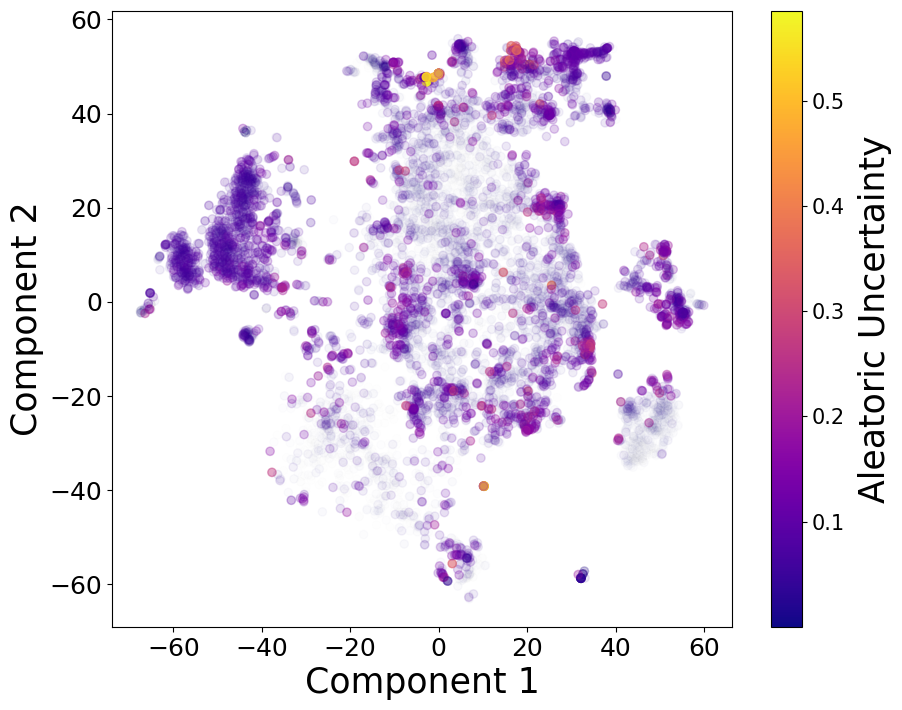

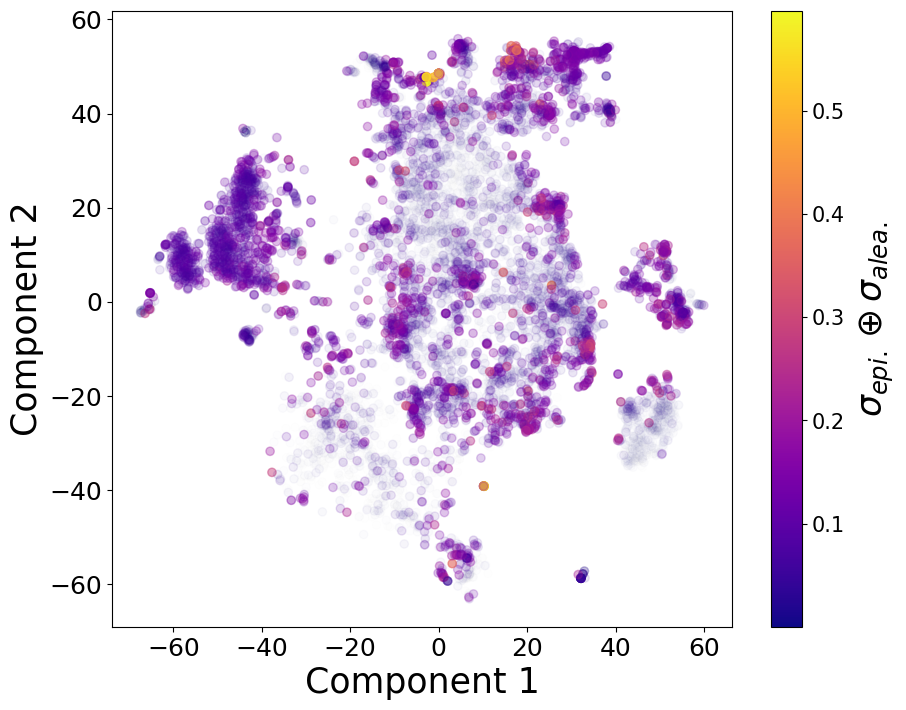

In [4]:
def create_plots(X_tsne,results,config,method,cmap='plasma'):
    if method == "BLOC":
        out_folder = config["Inference"]['out_dir_BLOC']
    elif method == "BOTOMETER":
        out_folder = config['Inference']['out_dir_BOTOMETER']
    else:
        print("Please choose method of either BOTOMETER or BLOC.")
        
    results['aleatoric'] = np.clip(results['aleatoric'].values,0,1)
    results['y_hat_sigma'] = np.clip(results['y_hat_sigma'].values,0,1)
        
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['label'] = y_test  # Assuming 'classes' is your array of class labels
    df_tsne['class'] = df_tsne['label'].map({0: 'Human', 1: 'Bot'})

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_tsne['Component 1'], df_tsne['Component 2'], c=df_tsne['label'], cmap='coolwarm', alpha=0.5)
    handles, labels = scatter.legend_elements()
    legend1 = plt.legend(handles, ['Human', 'Bot'], fontsize=22, loc='upper left',markerscale=3)

    for handle in legend1.legendHandles:
        handle.set_alpha(1)  

    plt.xlabel("Component 1", fontsize=25)
    plt.ylabel("Component 2", fontsize=25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(os.path.join(out_folder,"tsne_classes.pdf"),bbox_inches="tight")
    plt.show()
    
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['uncertainty'] = results['y_hat_sigma'] 

    min_uncertainty = df_tsne['uncertainty'].min()
    max_uncertainty = df_tsne['uncertainty'].max()
    df_tsne['alpha'] = (df_tsne['uncertainty'] - min_uncertainty) / (max_uncertainty - min_uncertainty)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_tsne['Component 1'], df_tsne['Component 2'], c=df_tsne['uncertainty'], cmap=cmap, alpha=df_tsne['alpha'])

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Epistemic Uncertainty', fontsize=25,labelpad=10)  # Colorbar label
    cbar.ax.tick_params(labelsize=15)  # Colorbar tick label size
    plt.xlabel("Component 1", fontsize=25)
    plt.ylabel("Component 2", fontsize=25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(os.path.join(out_folder,"tsne_epistemic.pdf"),bbox_inches="tight")
    plt.show()
    
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['uncertainty'] = results['aleatoric'] 

    plt.figure(figsize=(10, 8))
    min_uncertainty = df_tsne['uncertainty'].min()
    max_uncertainty = df_tsne['uncertainty'].max()
    df_tsne['alpha'] = (df_tsne['uncertainty'] - min_uncertainty) / (max_uncertainty - min_uncertainty)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_tsne['Component 1'], df_tsne['Component 2'], c=df_tsne['uncertainty'], cmap=cmap, alpha=df_tsne['alpha'])


    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Aleatoric Uncertainty', fontsize=25,labelpad=10)  # Colorbar label
    cbar.ax.tick_params(labelsize=15)  # Colorbar tick label size
    plt.xlabel("Component 1", fontsize=25)
    plt.ylabel("Component 2", fontsize=25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(os.path.join(out_folder,"tsne_aleatoric.pdf"),bbox_inches="tight")
    plt.show()
    
    df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
    df_tsne['uncertainty'] = np.clip(np.sqrt(results['aleatoric'].values ** 2 + results['y_hat_sigma'].values ** 2 ),0,1)

    min_uncertainty = df_tsne['uncertainty'].min()
    max_uncertainty = df_tsne['uncertainty'].max()
    df_tsne['alpha'] = (df_tsne['uncertainty'] - min_uncertainty) / (max_uncertainty - min_uncertainty)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df_tsne['Component 1'], df_tsne['Component 2'], c=df_tsne['uncertainty'], cmap=cmap, alpha=df_tsne['alpha'])


    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(r'$\sigma_{epi.} \oplus \sigma_{alea.}$', fontsize=25,labelpad=10)  # Colorbar label
    cbar.ax.tick_params(labelsize=15)  # Colorbar tick label size
    plt.xlabel("Component 1", fontsize=25)
    plt.ylabel("Component 2", fontsize=25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.savefig(os.path.join(out_folder,"tsne_quadrature.pdf"),bbox_inches="tight")
    plt.show()
    
    
create_plots(X_tsne,results_bloc,config,"BLOC")

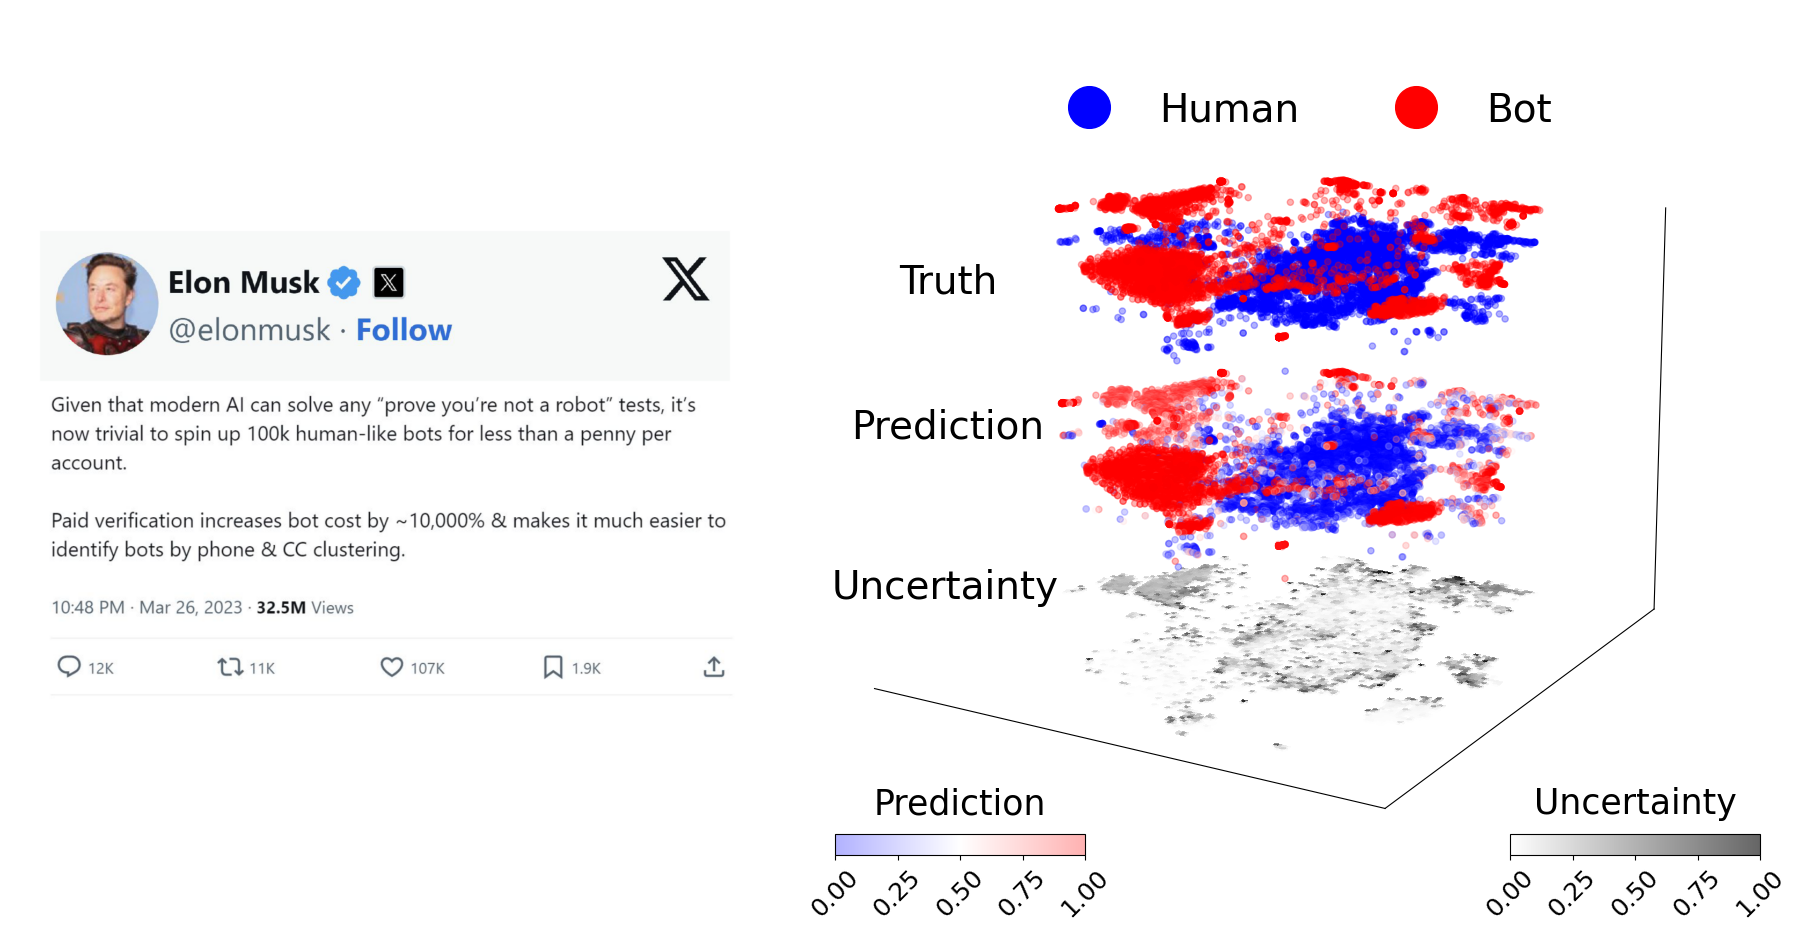

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
from pdf2image import convert_from_path

def create_3D_plots(X_tsne, results, config, method, y_test, cmap='plasma', sample_frac=0.1, alpha=0.5):
    
    if method == "BLOC":
        out_folder = config["Inference"]['out_dir_BLOC']
    elif method == "BOTOMETER":
        out_folder = config['Inference']['out_dir_BOTOMETER']
    else:
        print("Please choose method of either BOTOMETER or BLOC.")
        return
    
    results['aleatoric'] = np.clip(results['aleatoric'].values, 0, 1)
    results['y_hat_sigma'] = np.clip(results['y_hat_sigma'].values, 0, 1)
        
    num_samples = int(sample_frac * len(results)) 
    max_index = len(results) 

    random_indices = np.random.choice(max_index, size=num_samples, replace=False)
    X_tsne_ = X_tsne[random_indices]
    
    fig = plt.figure(figsize=(25, 15))
    fig.patch.set_facecolor('white')

    # Add an axes for the image
    img_ax = fig.add_axes([0.0, 0.1, 0.3, 0.8])
    img_ax.axis('off')  # Hide the axes
    #img = mpimg.imread('elon_tweet.png')  # Update with your image path
    images = convert_from_path('elon_tweet.pdf')
    img = images[0]  # Get the first page as image
    img_ax.imshow(img)
    
    #fig = plt.figure(figsize=(15, 10))
    #fig.patch.set_facecolor('white')
    ax = fig.add_subplot(111, projection='3d')
    
    #[left, bottom, width, height]
    # Layer 1: Uncertainty (normalized)
    df_tsne_uncertainty = pd.DataFrame(X_tsne_, columns=['Component 1', 'Component 2'])
    df_tsne_uncertainty['Component 3'] = np.ones_like(X_tsne_[:, 0]) * (-6)
    df_tsne_uncertainty['uncertainty'] = np.clip(np.sqrt(results['y_hat_sigma'].values[random_indices] ** 2 + results['aleatoric'].values[random_indices] ** 2), 0, 1)

    x_bins = np.linspace(np.min(df_tsne_uncertainty['Component 1']), np.max(df_tsne_uncertainty['Component 1']), 100)
    y_bins = np.linspace(np.min(df_tsne_uncertainty['Component 2']), np.max(df_tsne_uncertainty['Component 2']), 100)
    X, Y = np.meshgrid(x_bins, y_bins)
    Z = np.zeros_like(X)

    for i in range(len(x_bins) - 1):
        for j in range(len(y_bins) - 1):
            mask = (
                (df_tsne_uncertainty['Component 1'] >= x_bins[i]) & (df_tsne_uncertainty['Component 1'] < x_bins[i + 1]) &
                (df_tsne_uncertainty['Component 2'] >= y_bins[j]) & (df_tsne_uncertainty['Component 2'] < y_bins[j + 1])
            )
            if np.sum(mask) > 0:
                Z[j, i] = np.mean(df_tsne_uncertainty['uncertainty'][mask])
            else:
                Z[j, i] = np.nan 

    Z = np.nan_to_num(Z, nan=0.0)
    
    norm = plt.Normalize(vmin=np.min(Z), vmax=np.max(Z) * 0.6)
    contour = ax.plot_surface(X, Y, np.ones_like(Z) * (-6), facecolors=plt.cm.binary(norm(Z)), alpha=0.6, rstride=1, cstride=1, cmap='binary', linewidth=1, antialiased=False)
    if method != "BOTOMETER":
        cbar_uncertainty = plt.colorbar(contour, ax=ax, shrink=1.0, aspect=12,orientation='horizontal')
        cbar_uncertainty.set_label('Uncertainty', fontsize=25, labelpad=15)
        cbar_uncertainty.ax.tick_params(labelsize=18,rotation=45)
        cbar_uncertainty.ax.xaxis.set_label_position('top')
        #cbar_uncertainty.ax.set_position([0.6, -0.4, 0.1, 0.6])
        cbar_uncertainty.ax.set_position([0.6, -0.35, 0.1, 0.6])
        cbar_uncertainty.set_ticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_zlim(-6, 6)
    ax.grid(False)
    ax.set_facecolor('white')  # Set background color
    ax.view_init(20)
    ax.w_xaxis.pane.set_edgecolor('white')
    ax.w_yaxis.pane.set_edgecolor('white')
    ax.w_zaxis.pane.set_edgecolor('white')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False

    # Layer 2: Labels
    df_tsne_labels = pd.DataFrame(X_tsne_, columns=['Component 1', 'Component 2'])
    df_tsne_labels['Component 3'] = np.ones_like(X_tsne_[:, 0]) * 6
    df_tsne_labels['label'] = y_test[random_indices]
    df_tsne_labels.loc[df_tsne_labels['label'] == 1.0, 'Component 3'] = 6
    df_tsne_labels.loc[df_tsne_labels['label'] == 0.0, 'Component 3'] = 5.
    df_tsne_labels['class'] = df_tsne_labels['label'].map({0: 'Human', 1: 'Bot'})

    
    # Scatter plot for labels
    scatter = ax.scatter(df_tsne_labels['Component 1'], df_tsne_labels['Component 2'], df_tsne_labels['Component 3'],c=df_tsne_labels['label'], cmap='bwr', alpha=alpha)
    if method == 'BLOC':
        handles, labels = scatter.legend_elements()
        legend1 = ax.legend(handles, ['Human', 'Bot'], fontsize=28, loc=(0.25,0.85), markerscale=5,ncol=2)
        ax.add_artist(legend1)
        for handle in legend1.legendHandles:
            handle.set_alpha(1) 
        legend1.get_frame().set_edgecolor('none')

    # Layer 3: Predictions (normalized)
    df_tsne_predictions = pd.DataFrame(X_tsne_, columns=['Component 1', 'Component 2'])
    df_tsne_predictions['Component 3'] = np.zeros_like(X_tsne_[:, 0])# * 0.5
    df_tsne_predictions['label'] = y_test[random_indices]
    df_tsne_predictions['prediction'] = results['y_hat'].values[random_indices]
    df_tsne_predictions.loc[df_tsne_predictions['label'] == 1.0, 'Component 3'] = 0.
    df_tsne_predictions.loc[df_tsne_predictions['label'] == 0.0, 'Component 3'] = -1
    scatter = ax.scatter(df_tsne_predictions['Component 1'], df_tsne_predictions['Component 2'], df_tsne_predictions['Component 3'], c=df_tsne_predictions['prediction'], cmap='bwr', alpha=alpha)
    
    # Add colorbar for predictions
    if method != "BOTOMETER":
        cbar_predictions = plt.colorbar(scatter, ax=ax, shrink=0.6, aspect=12,orientation='horizontal')
        cbar_predictions.set_label('Prediction', fontsize=25, labelpad=15)
        cbar_predictions.ax.xaxis.set_label_position('top')
        cbar_predictions.ax.tick_params(labelsize=18,rotation=45)
        #cbar_predictions.ax.set_position([0.6, -0.3, 0.1, 0.6])
        cbar_predictions.ax.set_position([0.33, -0.35, 0.1, 0.6])
        cbar_predictions.set_ticks([0, 0.25, 0.5, 0.75, 1])

   
    
    if method == "BOTOMETER":
        ax.text(55,8,7,r'Truth',fontsize=22)
        ax.text(50,8,2,r'$<P_{bot.}>$',fontsize=22)
        ax.text(45,8,-3.5,r'$\sigma_{epi.} \oplus \sigma_{alea.}$',fontsize=22,zorder=10)
        #ax.set_xlabel("Botometer Features",fontsize=25)
    elif method == "BLOC":
        ax.text(-125,8,2,r'Truth',fontsize=28)
        ax.text(-142,8,-3,r'Prediction',fontsize=28)
        #ax.text(-150,8,-8.5,r'$\sigma_{epi.} \oplus \sigma_{alea.}$',fontsize=28,zorder=10)
        ax.text(-150,8,-8.5,r'Uncertainty',fontsize=28,zorder=10)
        #ax.set_xlabel("Bloc Features",fontsize=25)
    else:
        print("Incorrect method")
        exit()
    #plt.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False,length=0)
    ax.set_position([0.2, 0.2, 0.6, 0.6])
    plt.savefig(os.path.join(out_folder,"tsne_3D.pdf"),bbox_inches="tight")
    plt.show()

create_3D_plots(X_tsne, results_bloc, config, method='BLOC', y_test=y_test, sample_frac=1.,alpha=0.3)

# BOTOMETER

Note these plots are not used. Plotting code is leftover incase it is useful for future works.

In [22]:
_,X_test,_,_,y_test,_ = return_data(config,method="BOTOMETER")

X = X_test.copy()
tsne = TSNE(n_components=2, random_state=0,perplexity=75)
X_tsne = tsne.fit_transform(X)

Creating Loaders.
Training on Botometer features.
Start to load the features
Using Z-Score scaler for BOTOMETER
Undersampling humans.
Training fraction:  0.6456643162231153 0.6456643162231153
Validation fraction:  0.13836024970303537 0.13836024970303537
Testing fraction:  0.13836024970303537 0.13836024970303537


In [23]:
results_botometer = pd.read_csv(os.path.join(config['Inference']['out_dir_BOTOMETER'],"Inference.csv"),sep=',',index_col=None)
results_botometer = results_botometer[results_botometer.method == 'Testing']
results_botometer

y_hat  y_hat_sigma  y_true  aleatoric   method  y_hat_mlp  \
0      0.007599     0.006475     0.0   0.002597  Testing   0.001487   
1      0.945535     0.026469     0.0   0.019818  Testing   0.971799   
2      0.924807     0.032505     1.0   0.030005  Testing   0.908755   
3      0.211952     0.081937     0.0   0.214471  Testing   0.218818   
4      0.999280     0.000921     1.0   0.002411  Testing   0.999957   
...         ...          ...     ...        ...      ...        ...   
10944  0.999313     0.000834     1.0   0.001703  Testing   0.999615   
10945  0.999624     0.000415     1.0   0.001024  Testing   0.999859   
10946  0.359528     0.129720     0.0   0.167409  Testing   0.738057   
10947  0.000101     0.000150     0.0   0.000056  Testing   0.000342   
10948  0.043540     0.026553     0.0   0.031742  Testing   0.199223   

       y_true_mlp  
0             0.0  
1             0.0  
2             1.0  
3             0.0  
4             1.0  
...           ...  
10944         1.0  
10945         1.0  
10946         0.0  
10947         0.0  
10948         0.0  

[10949 rows x 7 columns]

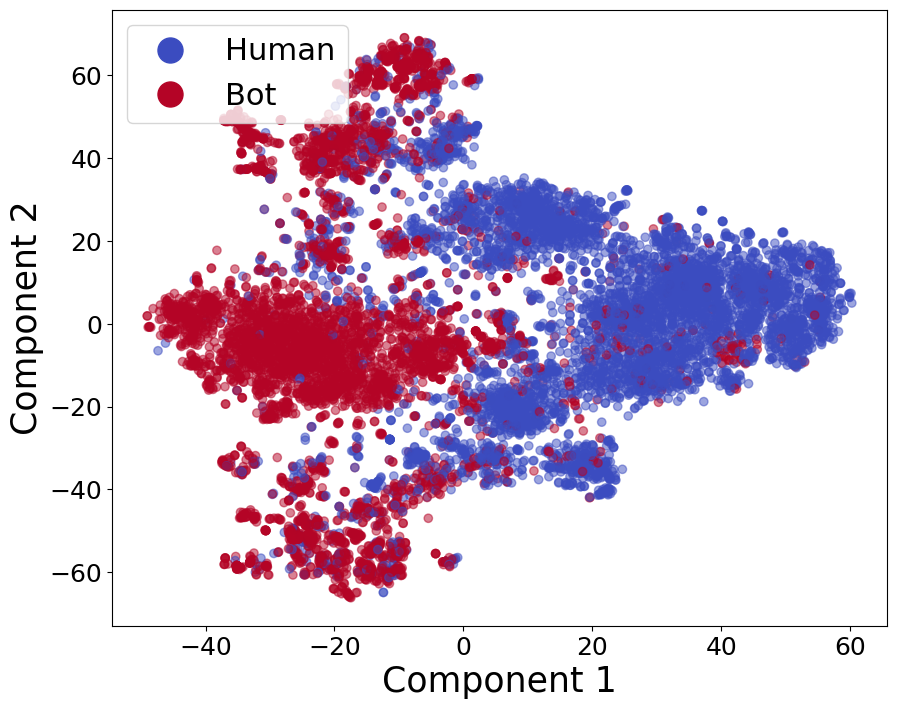

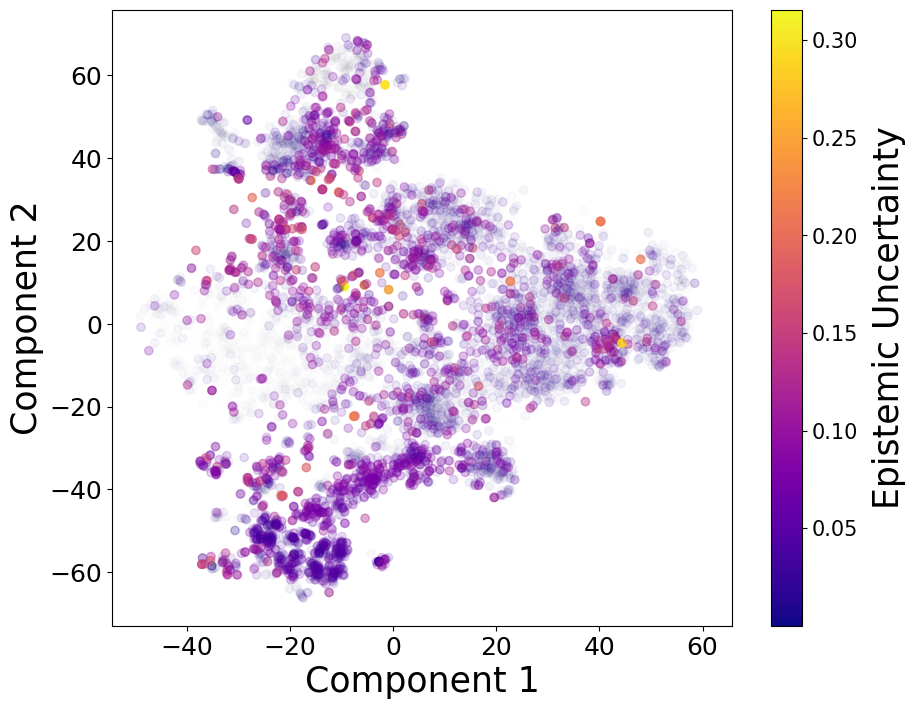

<Figure size 1000x800 with 0 Axes>

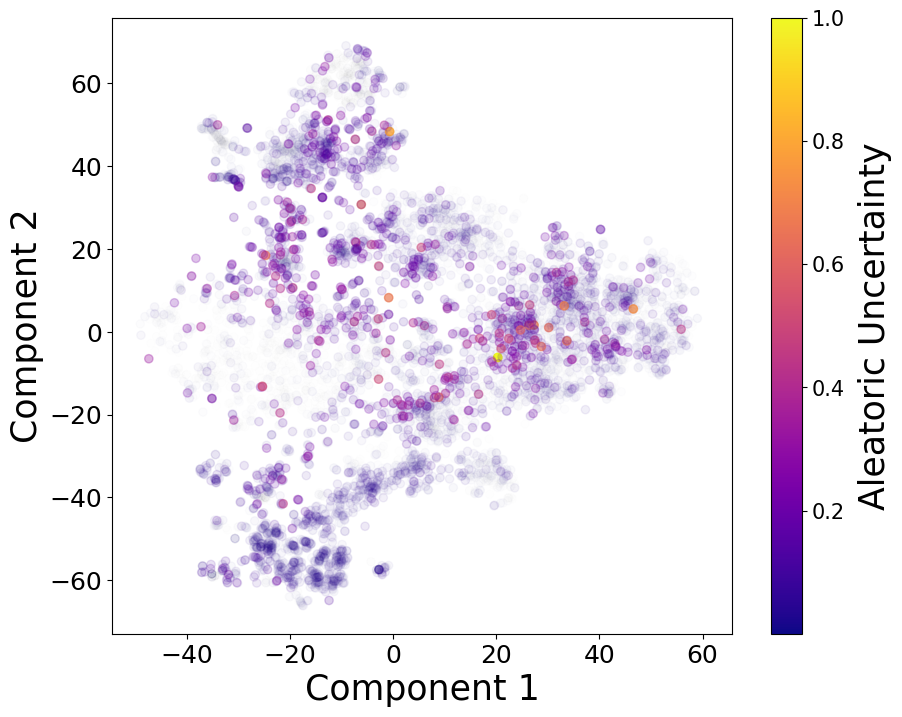

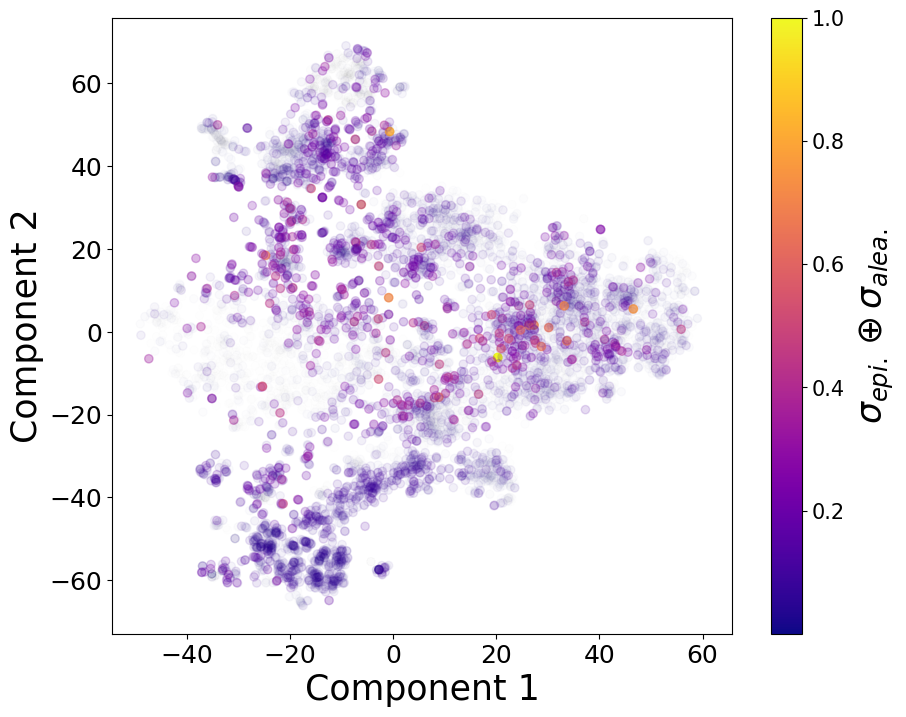

In [132]:
create_plots(X_tsne,results_botometer,config,"BOTOMETER")

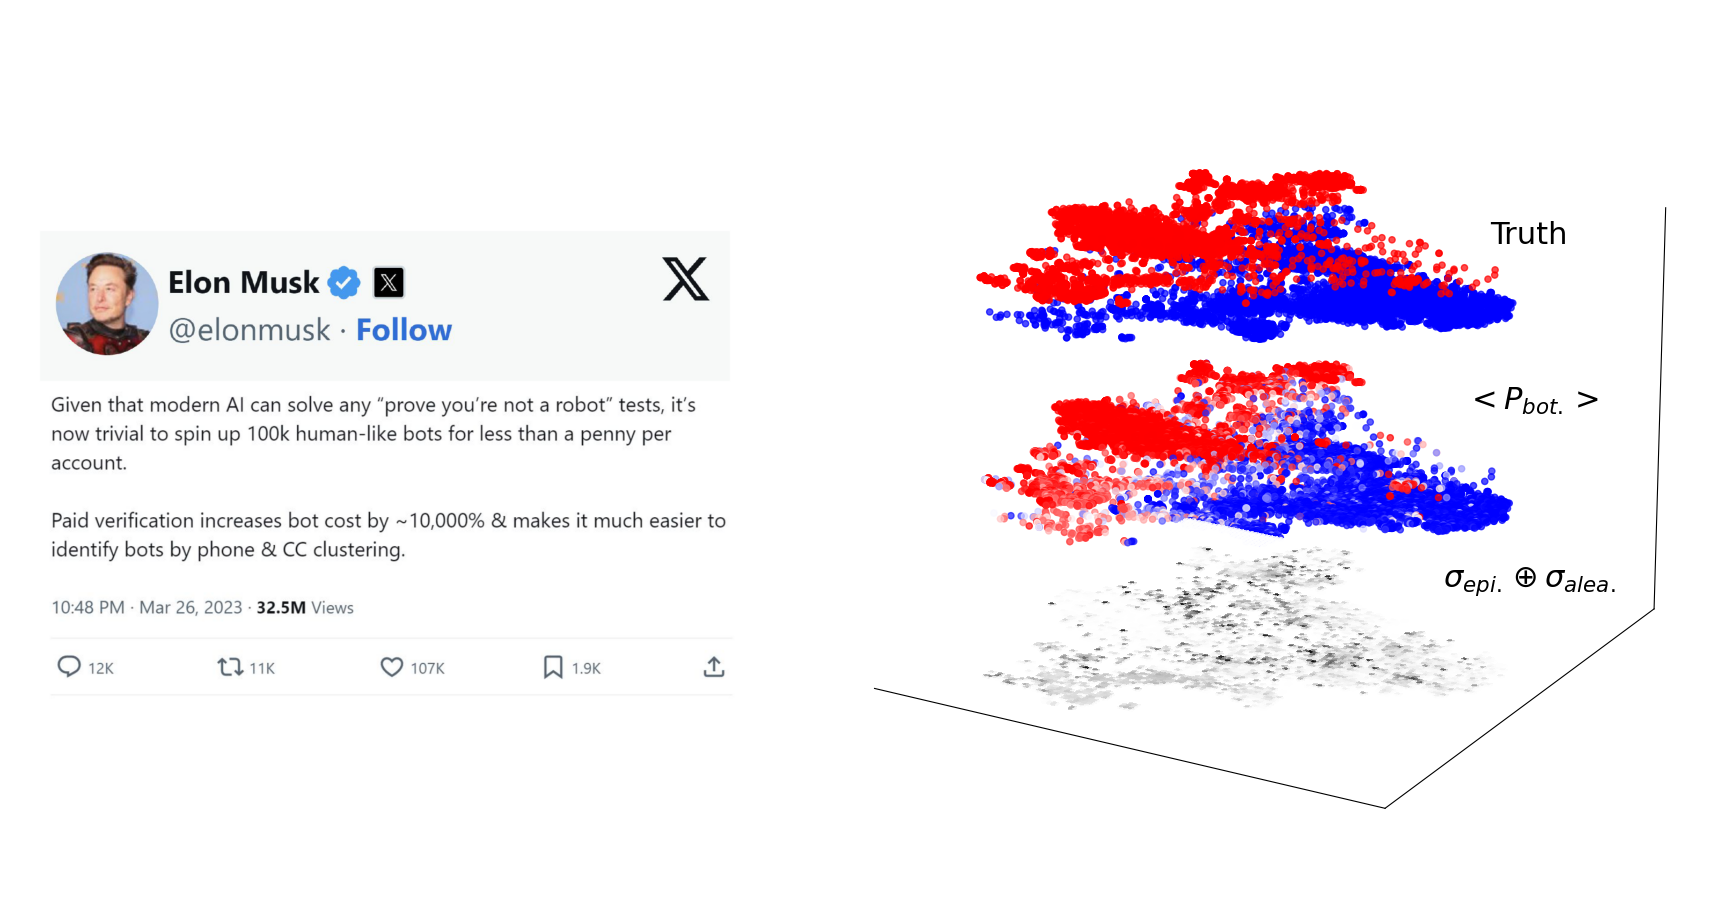

In [24]:
create_3D_plots(X_tsne,results_botometer,config,method='BOTOMETER',y_test=y_test,sample_frac=1.0,alpha=0.7)

# Uncertainty Informed Decision Making

In [7]:
from sklearn.metrics import accuracy_score,classification_report


#### WIP #######
def run_analysis(results):
    epistemic = results['y_hat_sigma'].values
    aleatoric = results['aleatoric'].values
    y_pred = results['y_hat'].values
    y_true = results['y_true'].values
    quad = np.sqrt(epistemic ** 2 + aleatoric ** 2)
    
    acc = accuracy_score(y_pred.round(),y_true)
    unc = np.sqrt(acc * (1.0 - acc)/len(y_pred))
    print("Baseline Accuracy: ",acc * 100, "% +- ",unc)
    report = classification_report(y_true, y_pred.round(), target_names=['Human', 'Bot'],zero_division=0)
    print(report)
    print(" ")
    
    idx = np.where((abs(y_pred - 0.5) > 3 * epistemic))[0]
    acc = accuracy_score(y_pred[idx].round(),y_true[idx])
    unc = np.sqrt(acc * (1.0 - acc)/len(idx))
    print("Epistemic 3 sigma cut: ",acc * 100,"% +- ",unc)
    print("Bot Fraction Rejected: ",1.0 - (y_true[idx] == 1.0).sum() / (y_true == 1.0).sum(), " Human Fraction Rejected: ",1.0 - (y_true[idx] == 0).sum() / (y_true == 0).sum())
    report = classification_report(y_true[idx], y_pred[idx].round(), target_names=['Human', 'Bot'],zero_division=0)
    print(report)
    print(" ")
    
    idx = np.where((abs(y_pred - 0.5) > 3 * aleatoric))[0]
    acc = accuracy_score(y_pred[idx].round(),y_true[idx])
    unc = np.sqrt(acc * (1.0 - acc)/len(idx))
    print("Aleatoric 3 sigma cut: ",acc * 100,"% +- ",unc)
    print("Bot Fraction Rejected: ",1.0 - (y_true[idx] == 1.0).sum() / (y_true == 1.0).sum(), " Human Fraction Rejected: ",1.0 - (y_true[idx] == 0).sum() / (y_true == 0).sum())
    report = classification_report(y_true[idx], y_pred[idx].round(), target_names=['Human', 'Bot'],zero_division=0)
    print(report)
    print(" ")    
    
    idx = np.where((abs(y_pred - 0.5) > 3 * quad))[0]
    acc = accuracy_score(y_pred[idx].round(),y_true[idx])
    unc = np.sqrt(acc * (1.0 - acc)/len(idx))
    print("Quadrature 3 sigma cut: ",acc * 100,"% +- ",unc)
    print("Bot Fraction Rejected: ",1.0 - (y_true[idx] == 1.0).sum() / (y_true == 1.0).sum(), " Human Fraction Rejected: ",1.0 - (y_true[idx] == 0).sum() / (y_true == 0).sum())
    report = classification_report(y_true[idx], y_pred[idx].round(), target_names=['Human', 'Bot'],zero_division=0)
    print(report)
    print(" ")    
    

print("BLOC:")
run_analysis(results_bloc)
print(" ")

print("BOTOMETER:")
run_analysis(results_botometer)

BLOC:
Baseline Accuracy:  92.47419855694584 % +-  0.002521154369106452
              precision    recall  f1-score   support

       Human       0.93      0.92      0.92      5462
         Bot       0.92      0.93      0.93      5487

    accuracy                           0.92     10949
   macro avg       0.92      0.92      0.92     10949
weighted avg       0.92      0.92      0.92     10949

 
Epistemic 3 sigma cut:  95.83633927651242 % +-  0.0020279150548110927
Bot Fraction Rejected:  0.10588664115181334  Human Fraction Rejected:  0.12175027462467958
              precision    recall  f1-score   support

       Human       0.96      0.96      0.96      4797
         Bot       0.96      0.96      0.96      4906

    accuracy                           0.96      9703
   macro avg       0.96      0.96      0.96      9703
weighted avg       0.96      0.96      0.96      9703

 
Aleatoric 3 sigma cut:  96.02732527588019 % +-  0.002002324786383634
Bot Fraction Rejected:  0.121560051029706